In [2]:
import torch
torch.__version__

'2.6.0.dev20241006'

In [10]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device

'mps'

In [13]:
#1 Binary Classification Dataset with make_moons from scikit-learn

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from torch import nn
from torchmetrics import Accuracy

In [138]:
SAMPLES = 1000
RANDOM_STATE = 42
X, y = make_moons(n_samples=SAMPLES, noise=0.07, random_state = RANDOM_STATE)
X = torch.tensor(X,dtype = torch.float)
y = torch.tensor(y,dtype = torch.float)

In [139]:
X[:10],y[:10]

(tensor([[-0.0334,  0.4214],
         [ 0.9988, -0.4429],
         [ 0.8896, -0.3278],
         [ 0.3420, -0.4177],
         [-0.8385,  0.5324],
         [ 0.5991, -0.2898],
         [ 0.2901, -0.2047],
         [-0.0383,  0.4594],
         [ 1.6138, -0.2940],
         [ 0.6933,  0.8278]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

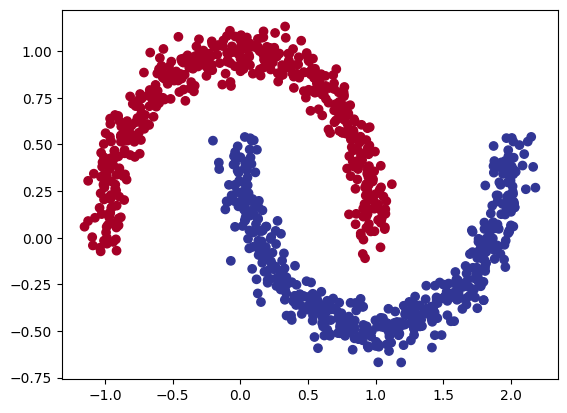

In [140]:
plt.scatter(X[:,0],X[:,1],c=y, cmap =plt.cm.RdYlBu)

In [141]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = RANDOM_STATE)

In [142]:
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [143]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [144]:
#2 Build a Non-Linear model by subclassing nn.Module

In [145]:
class BinaryClassificationModel(nn.Module):
    def __init__(self,input_units,hidden_units):
        super().__init__()
        self.layer = nn.Sequential(nn.Linear(in_features=input_units,out_features=hidden_units),
        nn.ReLU(),
                                   nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
                                   nn.Linear(in_features=hidden_units, out_features=1)
                                   )
        #self.relu = 
    def forward(self,x):
        return self.layer(x)

bc_model = BinaryClassificationModel(2,10).to(device)
bc_model.parameters

<bound method Module.parameters of BinaryClassificationModel(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)>

In [146]:
#3 Binary Class loss fn and Optimizer

In [147]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(bc_model.parameters(), lr = 0.1)
acc_fn = Accuracy(task = 'multiclass', num_classes=2).to(device)
acc_fn

MulticlassAccuracy()

In [148]:
#4 Train nd test loop to fit model created

In [149]:
print(bc_model(X_train.to(device)[:10]))

tensor([[0.2394],
        [0.1744],
        [0.1846],
        [0.1854],
        [0.1841],
        [0.1836],
        [0.1901],
        [0.1808],
        [0.2005],
        [0.1733]], device='mps:0', grad_fn=<LinearBackward0>)


In [150]:
epochs = 1000

X_train, y_train = X_train.to(device),y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    bc_model.train()

    y_logits = bc_model(X_train).squeeze()

    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)

    acc = acc_fn(y_preds, y_train.int())
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    bc_model.eval()

    with torch.inference_mode():
        test_logits = bc_model(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_preds, y_test.int())
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")
     
        
    

Epoch: 0 | Loss: 0.69 Acc: 0.50 | Test loss: 0.69 Test acc: 0.50
Epoch: 100 | Loss: 0.49 Acc: 0.80 | Test loss: 0.51 Test acc: 0.77
Epoch: 200 | Loss: 0.33 Acc: 0.87 | Test loss: 0.34 Test acc: 0.86
Epoch: 300 | Loss: 0.26 Acc: 0.90 | Test loss: 0.27 Test acc: 0.90
Epoch: 400 | Loss: 0.23 Acc: 0.92 | Test loss: 0.22 Test acc: 0.90
Epoch: 500 | Loss: 0.19 Acc: 0.93 | Test loss: 0.19 Test acc: 0.92
Epoch: 600 | Loss: 0.16 Acc: 0.94 | Test loss: 0.15 Test acc: 0.94
Epoch: 700 | Loss: 0.12 Acc: 0.96 | Test loss: 0.12 Test acc: 0.98
Epoch: 800 | Loss: 0.09 Acc: 0.99 | Test loss: 0.08 Test acc: 0.99
Epoch: 900 | Loss: 0.06 Acc: 1.00 | Test loss: 0.06 Test acc: 1.00


In [151]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


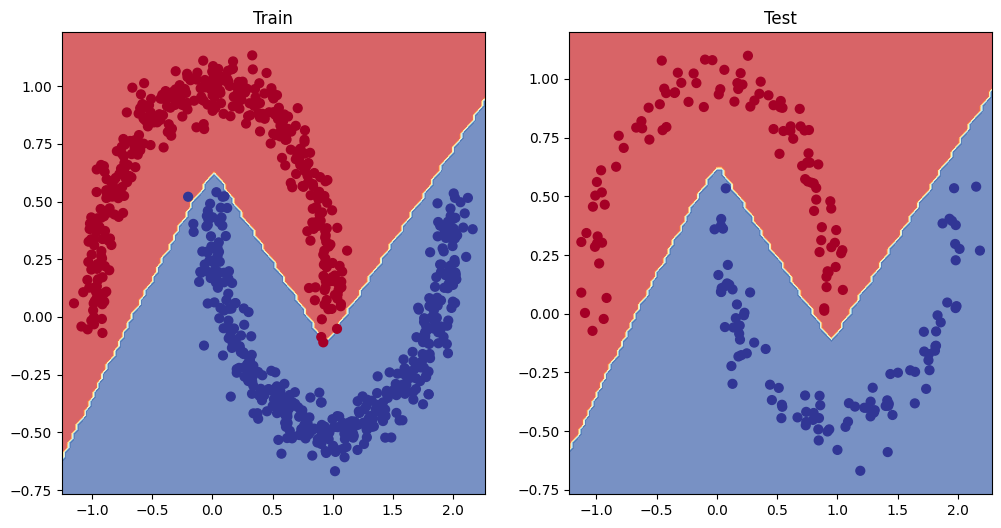

In [154]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(bc_model,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(bc_model,X_test,y_test)


In [155]:
#6 replicate tanh function in pytorch

In [160]:
import numpy as np
def tanh(z):
	return (torch.exp(z) - torch.exp(-z)) / (torch.exp(z) + torch.exp(-z))

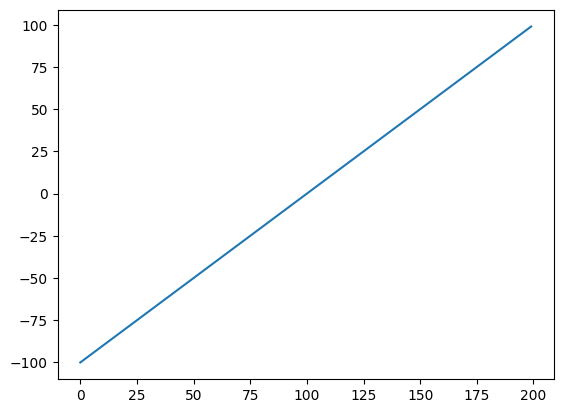

In [162]:
tensor_a = torch.arange(-100,100,1)
plt.plot(tensor_a)

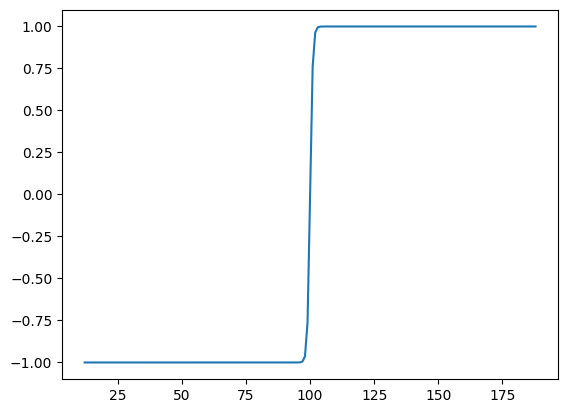

In [163]:
plt.plot(tanh(tensor_a))

In [164]:
#7 Multi class dataset

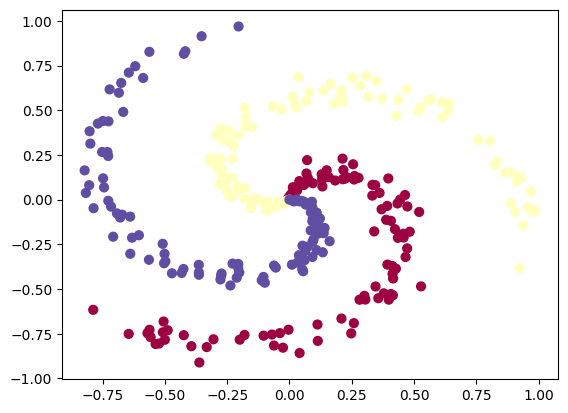

In [203]:
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [204]:
X.shape, y.shape

((300, 2), (300,))

In [205]:
X[:5],y[:5]

(array([[-0.        ,  0.        ],
        [-0.00489579,  0.00883525],
        [ 0.00133354,  0.02015796],
        [ 0.00590103,  0.02972291],
        [ 0.01421282,  0.03782172]]),
 array([0, 0, 0, 0, 0], dtype=uint8))

In [206]:
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.LongTensor).to(device)

In [207]:
class MultiClassModel(nn.Module):
    def __init__(self, in_units, hidden_units, out_units):
        super().__init__()
        self.layer = nn.Sequential(nn.Linear(in_features = in_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = out_units)
                                  )

    def forward(self, x):
            return self.layer(x)

multi_model = MultiClassModel(2,10,3).to(device)
print(multi_model)

MultiClassModel(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)


In [208]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = RANDOM_STATE)

In [209]:
len(X_train),len(y_train)

(240, 240)

In [210]:
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

In [214]:
print(torch.softmax(multi_model(X_train[:5]),dim = 1).argmax(dim=1))

tensor([0, 0, 0, 0, 0], device='mps:0')


In [215]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(multi_model.parameters(), lr = 0.1)
acc_fn = Accuracy(task = 'multiclass', num_classes=3).to(device)

In [217]:
epochs = 1000

for epoch in range(epochs):
    multi_model.train()
    y_probs = multi_model(X_train).squeeze()
    y_pred = torch.softmax(y_probs, dim = 1).argmax(dim = 1)
    
    loss = loss_fn(y_probs, y_train)
    acc = acc_fn(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    multi_model.eval()
    with torch.inference_mode():
        test_probs = multi_model(X_test).squeeze()
        test_pred = torch.softmax(test_probs, dim = 1).argmax(dim = 1)
        test_loss = loss_fn(test_probs, y_test)
        test_acc = acc_fn(test_pred, y_test)
        if epoch%100 == 0:
            print(f"Epoch:{epoch} | Loss: {loss:.2f} | Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")
    

Epoch:0 | Loss: 1.08 | Acc: 0.47 | Test loss: 1.05 Test acc: 0.40
Epoch:100 | Loss: 0.03 | Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch:200 | Loss: 0.02 | Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch:300 | Loss: 0.02 | Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch:400 | Loss: 0.02 | Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch:500 | Loss: 0.02 | Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch:600 | Loss: 0.02 | Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch:700 | Loss: 0.02 | Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch:800 | Loss: 0.02 | Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch:900 | Loss: 0.02 | Acc: 0.99 | Test loss: 0.00 Test acc: 1.00


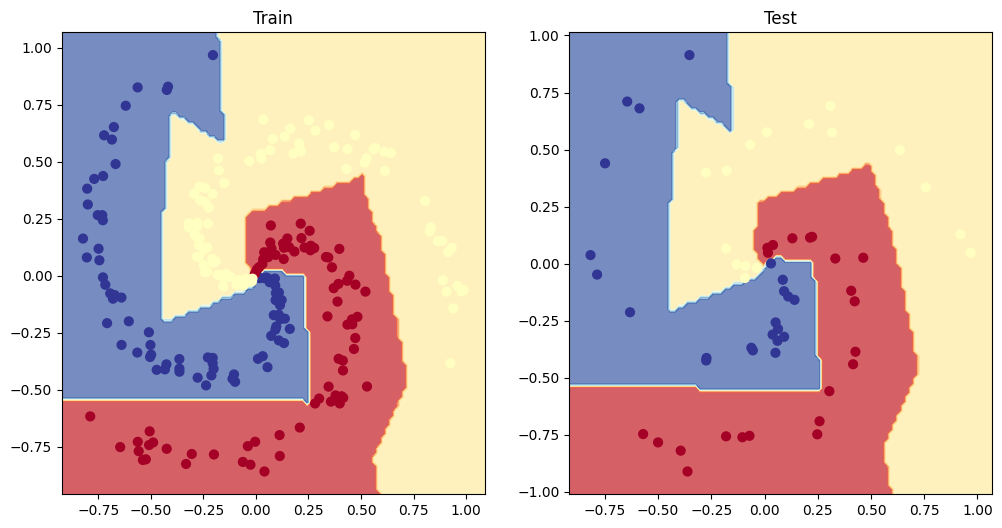

In [218]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(multi_model, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(multi_model, X_test, y_test)